In [60]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from src.PerformanceAnalyzer import PerformanceAnalyzerCDDM

In [61]:
RNN_folder = "0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
LC_folder = "0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
print(RNN_folder)
RNN_score = float(RNN_folder.split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
LC_folder_path = os.path.join('../', "data", "inferred_LCs", LC_folder)

0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000


In [62]:
subfolders = os.listdir(LC_folder_path)
ind = 0
max_score = -10
for i, subfolder in enumerate(subfolders):
    if "8nodes" in subfolder or "8-nodes" in subfolder:
        score = float(subfolder.split("_")[0])
        if max_score <= score:
            max_score = score
            ind = i 
LC_subfolder = subfolders[ind]
LC_path = os.path.join('../', "data", "inferred_LCs", LC_folder, LC_subfolder)

In [63]:
LC_data = json.load(open(os.path.join(LC_path, f"{max_score}_LC_params.json"), "rb+"))


In [64]:
U = np.array(LC_data["U"])
q = np.array(LC_data["q"])
Q = U.T @ q
w_out = np.array(LC_data["W_out"])
w_rec = np.array(LC_data["W_rec"])
w_inp = np.array(LC_data["W_inp"])
n = LC_data["n"]
N = LC_data["N"]
dt = LC_data["dt"]
tau = LC_data["tau"]

In [65]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_CDDM.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [66]:
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]

rnn_config = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_CDDM.json"), "rb+"))
train_config_file = f"train_config_CDDM_relu.json"

In [67]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

In [68]:
RNN_valid = RNN_numpy(N=W_rec.shape[0],
                      dt=rnn_data["dt"],
                      tau=rnn_data["tau"],
                      activation = lambda x: np.maximum(0, x),
                      W_inp=np.array(rnn_data["W_inp"]),
                      W_rec=np.array(rnn_data["W_rec"]),
                      W_out=np.array(rnn_data["W_out"]),
                      bias_rec=None,
                      y_init=np.zeros(W_rec.shape[0]))


analyzer = PerformanceAnalyzerCDDM(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

0.0119081


Plotting random trials


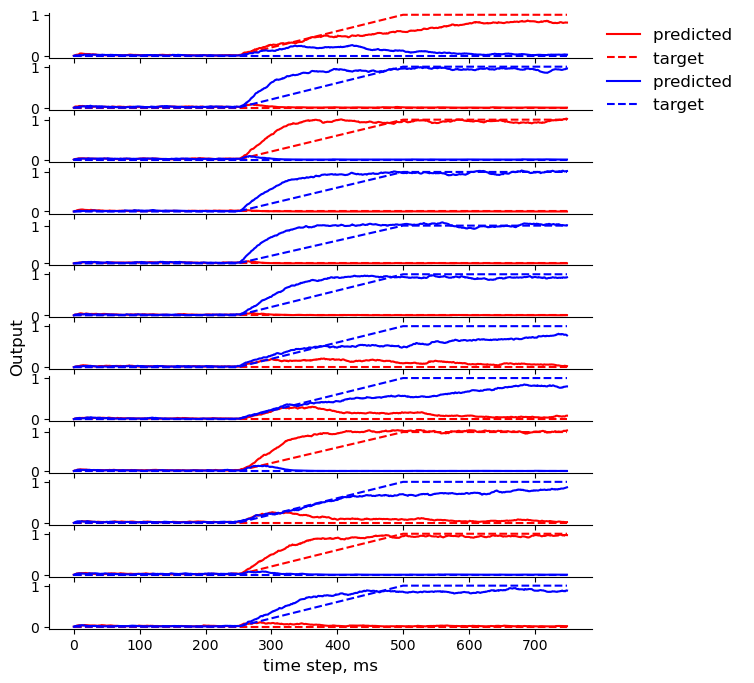

Plotting psychometric data


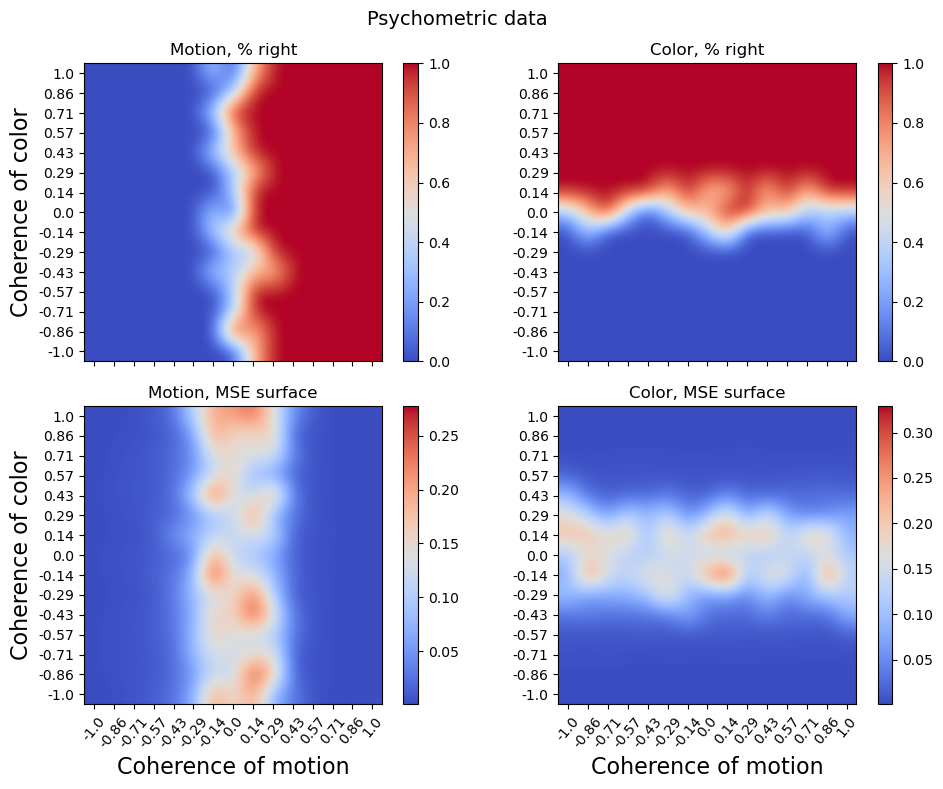

In [69]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
plt.show()

print(f"Plotting psychometric data")
num_levels = len(task_params["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=3, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

# pruning

In [90]:
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)
RNN_valid.sigma_rec = RNN_valid.sigma_inp = 0
y, predicted_output_rnn = RNN_valid.run_multiple_trajectories(input_batch, sigma_rec=0, sigma_inp=0)
Y = np.hstack([y[:, :, i] for i in range(y.shape[-1])])

In [91]:
# removing silent neurons and z-scoring the responses
Y_mean = np.mean(np.abs(Y.T), axis=0)
inds_fr = np.where(Y_mean > 1e-4)[0]
Y = Y[inds_fr, :]

In [92]:
W_rec_pruned = np.take(np.take(W_rec, inds_fr, axis = 0), inds_fr, axis = 1)
W_inp_pruned = np.take(W_inp, inds_fr, axis = 0)
W_out_pruned = np.take(W_out, inds_fr, axis = 1)

0.0119082
Plotting random trials


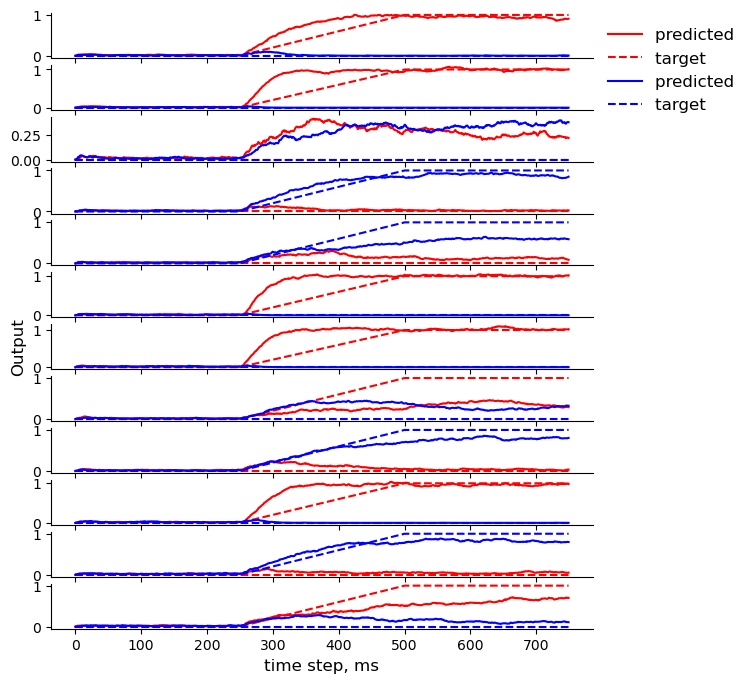

Plotting psychometric data


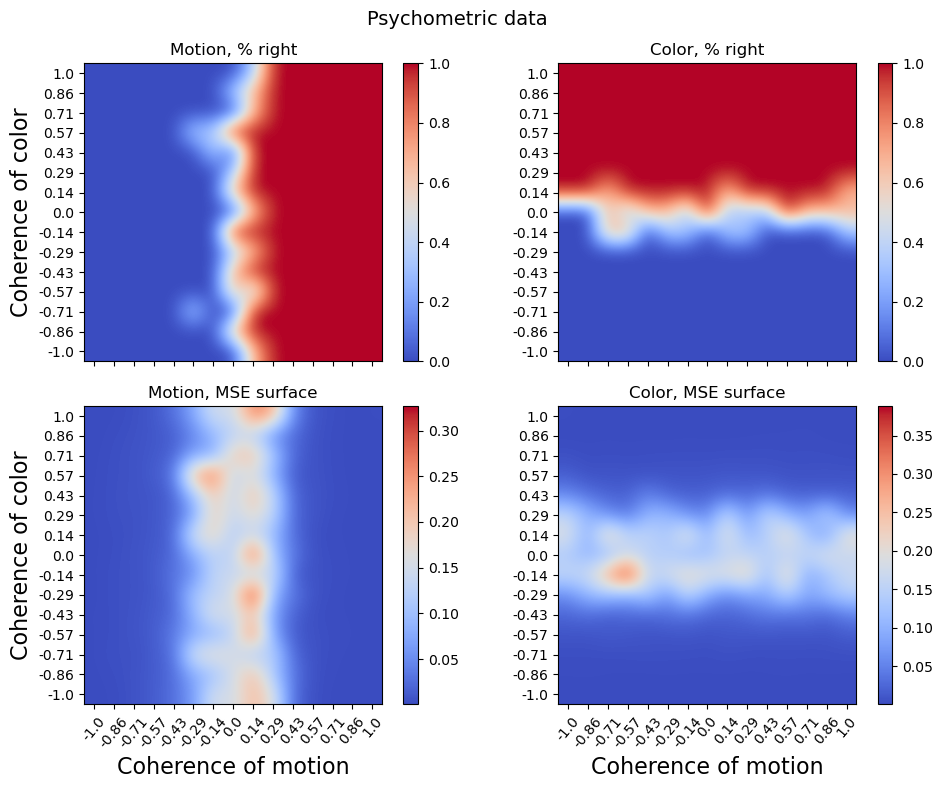

In [93]:
RNN_pruned = RNN_numpy(N=W_rec_pruned.shape[0],
              dt=rnn_data["dt"],
              tau=rnn_data["tau"],
              activation = lambda x: np.maximum(0, x),
              W_inp=W_inp_pruned,
              W_rec=W_rec_pruned,
              W_out=W_out_pruned,
              bias_rec=None,
              y_init=np.zeros(W_rec_pruned.shape[0]))

analyzer = PerformanceAnalyzerCDDM(RNN_pruned)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
plt.show()

print(f"Plotting psychometric data")
num_levels = len(task_params["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=3, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

In [94]:
# now:
# take the neuron with the lowest firing rate
# regress it by the other neural traces obtaining coefficients (N-1)
# redistribute the connectivity of the eliminated neuron by adding its connecitivity to the rest of the neurons


In [152]:
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)
RNN = deepcopy(RNN_pruned)
W_rec = deepcopy(W_rec_pruned)
W_inp = deepcopy(W_inp_pruned)
W_out = deepcopy(W_out_pruned)
for n in range(10):
    y, predicted_output_rnn = RNN.run_multiple_trajectories(input_batch, sigma_rec=0, sigma_inp=0)
    Y = np.hstack([y[:, :, i] for i in range(y.shape[-1])])
    Y_mean = np.mean(np.abs(Y.T), axis=0)

    indices = np.argsort(Y_mean)
    ind_min = indices[0] #take the nrn with the lowest firing rate
    inds_rest = np.arange(len(Y_mean)).tolist()
    inds_rest.remove(ind_min)
    b = Y[ind_min, :]
    Y_rest = np.take(Y, inds_rest, axis = 0)

    betas = lsqr(Y_rest.T, b, damp=2)[0] #find the regression coefficients for the rest of the neurons

    rec_from = np.take(W_rec[:, ind_min], inds_rest)
    rec_to = np.take(W_rec[ind_min, :], inds_rest)
    inp = W_inp[ind_min, :]
    out = W_out[:, ind_min]

    W_rec_new = np.take(np.take(deepcopy(W_rec), inds_rest, axis=0), inds_rest, axis = 1)
    W_out_new = np.take(deepcopy(W_out), inds_rest, axis=1)
    W_inp_new = np.take(deepcopy(W_inp), inds_rest, axis=0)
    
    for i in range(len(Y_rest)):
        W_rec_new[:, i] += betas[i] * rec_from
        W_rec_new[i, :] += betas[i] * rec_to
        W_out_new[:, i] += betas[i] * out
        W_inp_new[i, :] += betas[i] * inp
        
    RNN = RNN_numpy(N=W_rec_new.shape[0],
              dt=rnn_data["dt"],
              tau=rnn_data["tau"],
              activation = lambda x: np.maximum(0, x),
              W_inp=deepcopy(W_inp_new),
              W_rec=deepcopy(W_rec_new),
              W_out=deepcopy(W_out_new),
              bias_rec=None,
              y_init=np.zeros(W_rec_new.shape[0]))
    print(W_rec_new.shape[0])
    W_rec = deepcopy(W_rec_new)
    W_inp = deepcopy(W_inp_new)
    W_out = deepcopy(W_out_new)

89
88
87
86
85
84
83
82
81
80


0.0320899
Plotting random trials


/Users/tolmach/Documents/GitHub/rnn_coach/src/PerformanceAnalyzer.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig_output.tight_layout()


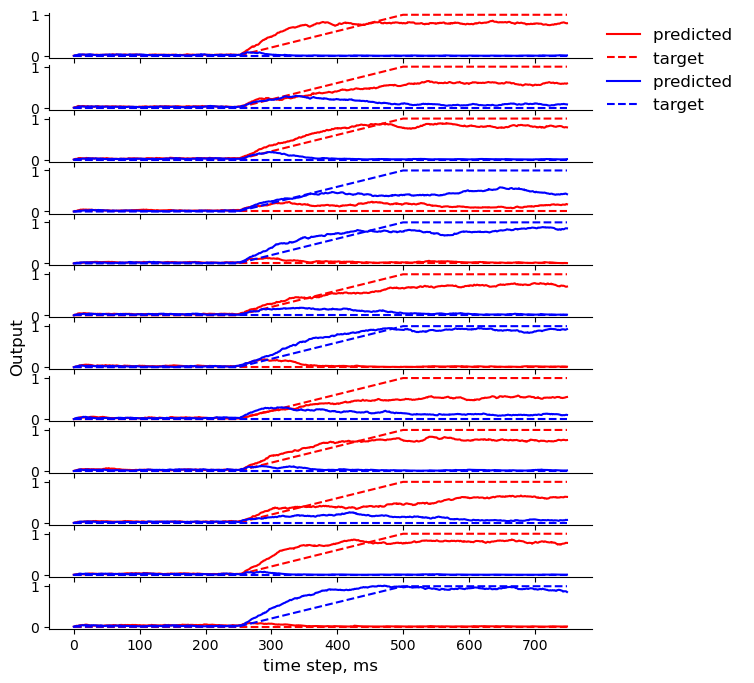

Plotting psychometric data


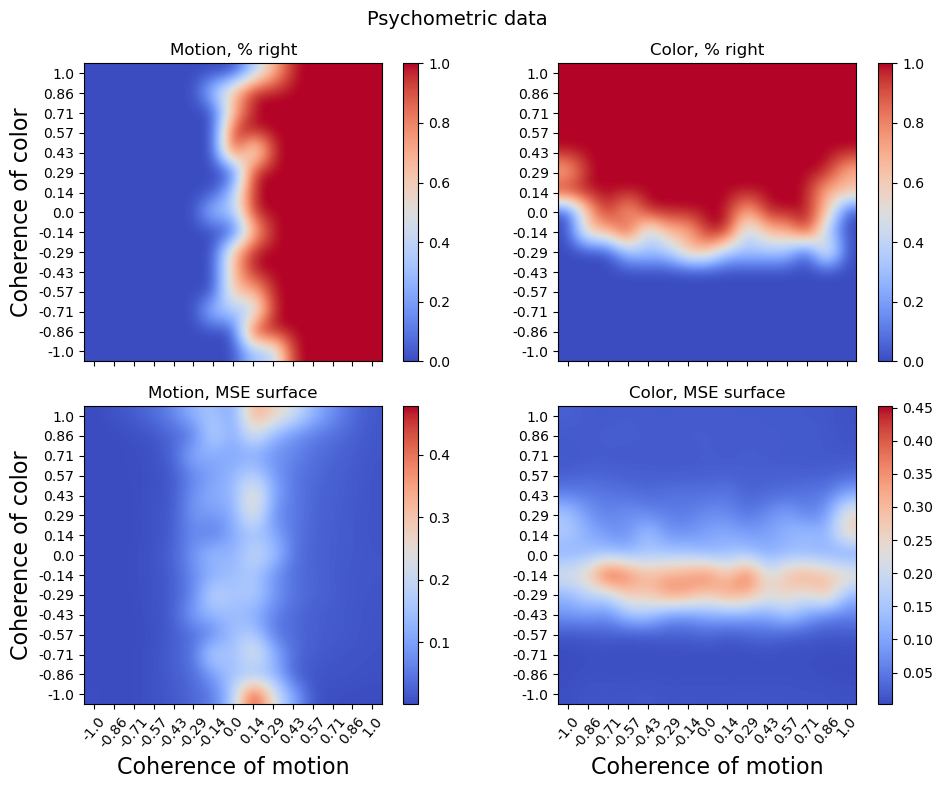

In [153]:
RNN_pruned = RNN_numpy(N=W_rec.shape[0],
              dt=rnn_data["dt"],
              tau=rnn_data["tau"],
              activation = lambda x: np.maximum(0, x),
              W_inp=W_inp,
              W_rec=W_rec,
              W_out=W_out,
              bias_rec=None,
              y_init=np.zeros(W_rec.shape[0]))

analyzer = PerformanceAnalyzerCDDM(RNN_pruned)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
plt.show()

print(f"Plotting psychometric data")
num_levels = len(task_params["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=3, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

In [155]:
W_rec.shape

(80, 80)

In [162]:
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)
for n in range(30):
    y, predicted_output_rnn = RNN.run_multiple_trajectories(input_batch, sigma_rec=0, sigma_inp=0)
    Y = np.hstack([y[:, :, i] for i in range(y.shape[-1])])
    Y_mean = np.mean(np.abs(Y.T), axis=0)

    indices = np.argsort(Y_mean)
    ind_min = indices[0] #take the nrn with the lowest firing rate
    inds_rest = np.arange(len(Y_mean)).tolist()
    inds_rest.remove(ind_min)
    b = Y[ind_min, :]
    Y_rest = np.take(Y, inds_rest, axis = 0)

    betas = lsqr(Y_rest.T, b, damp=10)[0] #find the regression coefficients for the rest of the neurons

    rec_from = np.take(W_rec[:, ind_min], inds_rest)
    rec_to = np.take(W_rec[ind_min, :], inds_rest)
    inp = W_inp[ind_min, :]
    out = W_out[:, ind_min]

    W_rec_new = np.take(np.take(deepcopy(W_rec), inds_rest, axis=0), inds_rest, axis = 1)
    W_out_new = np.take(deepcopy(W_out), inds_rest, axis=1)
    W_inp_new = np.take(deepcopy(W_inp), inds_rest, axis=0)
    
#     for i in range(len(Y_rest)):
#         W_rec_new[:, i] += betas[i] * rec_from
#         W_rec_new[i, :] += betas[i] * rec_to
#         W_out_new[:, i] += betas[i] * out
#         W_inp_new[i, :] += betas[i] * inp

    W_rec_new += betas.reshape(-1, 1) @ rec_to.reshape(1, -1)
    W_inp_new += betas.reshape(-1, 1) @ inp.reshape(1, -1)
    W_rec_new += rec_from.reshape(-1, 1) @ betas.reshape(1, -1)
    W_out_new += out.reshape(-1, 1) @ betas.reshape(1, -1)
        
    RNN = RNN_numpy(N=W_rec_new.shape[0],
              dt=rnn_data["dt"],
              tau=rnn_data["tau"],
              activation = lambda x: np.maximum(0, x),
              W_inp=deepcopy(W_inp_new),
              W_rec=deepcopy(W_rec_new),
              W_out=deepcopy(W_out_new),
              bias_rec=None,
              y_init=np.zeros(W_rec_new.shape[0]))
    
    print(W_rec_new.shape[0])
    W_rec = deepcopy(W_rec_new)
    W_inp = deepcopy(W_inp_new)
    W_out = deepcopy(W_out_new)

75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46


0.1780006
Plotting random trials


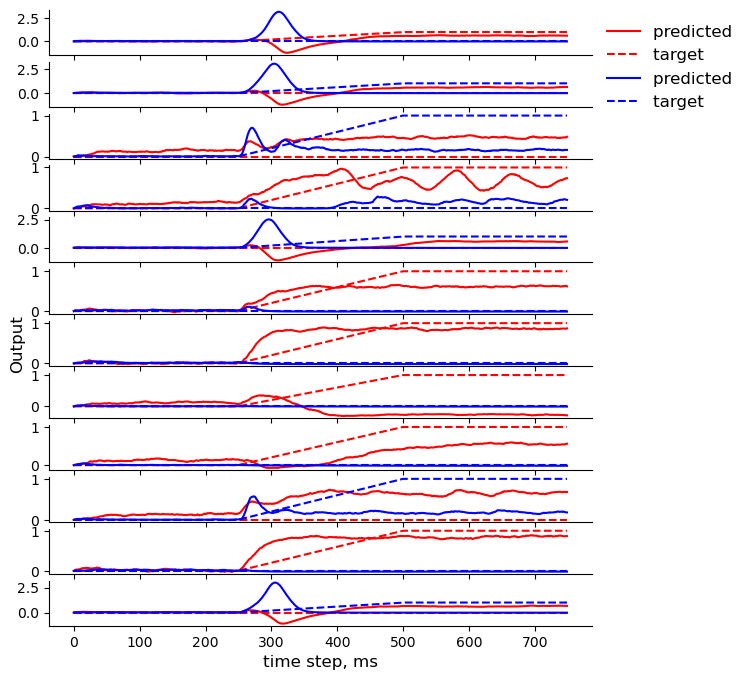

Plotting psychometric data


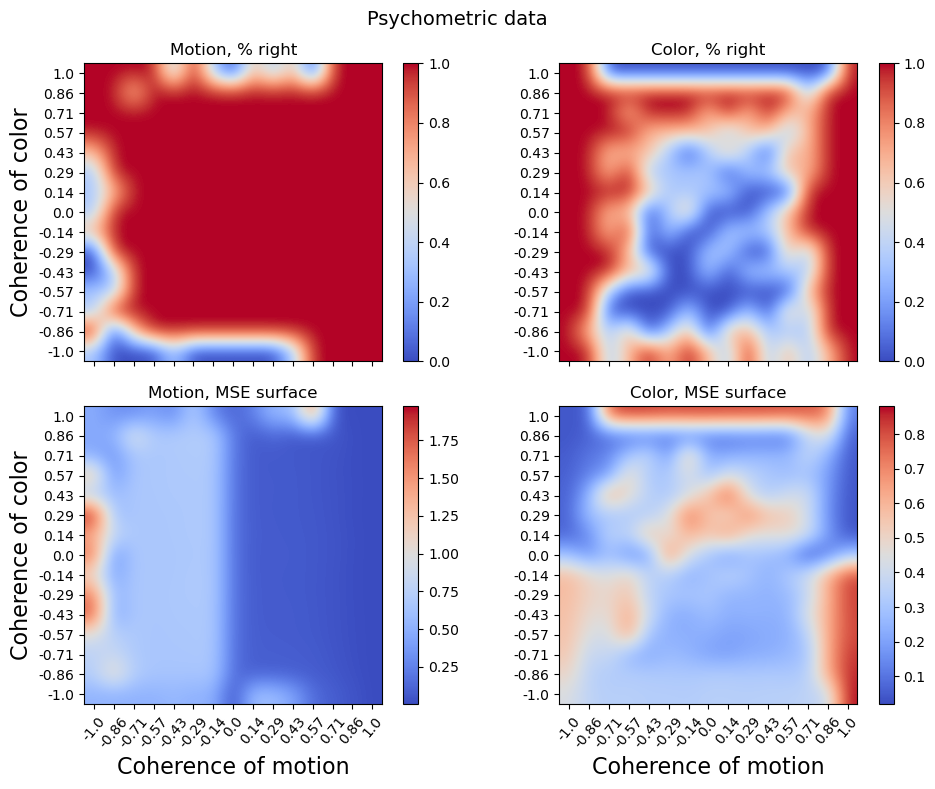

In [164]:
RNN_pruned = RNN_numpy(N=W_rec.shape[0],
              dt=rnn_data["dt"],
              tau=rnn_data["tau"],
              activation = lambda x: np.maximum(0, x),
              W_inp=W_inp,
              W_rec=W_rec,
              W_out=W_out,
              bias_rec=None,
              y_init=np.zeros(W_rec.shape[0]))

analyzer = PerformanceAnalyzerCDDM(RNN_pruned)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
plt.show()

print(f"Plotting psychometric data")
num_levels = len(task_params["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=3, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()